In [5]:
import pandas as pd
df = pd.read_csv('../data/imbalanced_dataset/imbalanced.csv')
df.tail()

,Score,Summary
147492,5,if its all natural this is like panacea of spi...
147493,5,very large ground spice jars
147494,5,will not do without
147495,5,perfect for our maltipoo
147496,5,favorite training and reward treat


In [6]:
print(df.isnull().sum())


Score      0
Summary    0
dtype: int64


In [7]:
print("Unique Score values:", df['Score'].unique())
print(df['Score'].value_counts())

Unique Score values: [5 2 1 4 3]
Score
5    89716
4    22877
1    13712
3    12663
2     8529
Name: count, dtype: int64


In [8]:
import re
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources (only first time)
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and normalize text
def clean_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove URLs and HTML tags
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)   # URLs
    text = re.sub(r'<.*?>', '', text)                    # HTML
    
    # 3. Remove emojis and non-alphabetic characters
    text = re.sub(r'[^\w\s]', '', text)                  # punctuation
    text = re.sub(r'[\d_]', '', text)                    # numbers and underscores
    text = re.sub(r'\s+', ' ', text).strip()             # extra spaces
    
    # 4. Tokenize
    tokens = nltk.word_tokenize(text)
    
    # 5. Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    # 6. Lemmatize (convert words to base form)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # 7. Rejoin tokens
    cleaned_text = ' '.join(tokens)
    return cleaned_text


# Apply cleaning to your dataset
df['Cleaned_summary'] = df['Summary'].astype(str).apply(clean_text)

# ✅ Remove any remaining numbers (like "2" in "2 good product")
df['Cleaned_summary'] = df['Cleaned_summary'].apply(lambda x: re.sub(r'\d+', '', x))

# 8. Filter out reviews with <3 words or extremely long text (>150 words)
df = df[df['Cleaned_summary'].apply(lambda x: len(x.split()) >= 3)]
df = df[df['Cleaned_summary'].apply(lambda x: len(x.split()) <= 150)]

print("⭐ Remaining samples after cleaning:", len(df))
df[['Cleaned_summary', 'Score']].head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91940\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


⭐ Remaining samples after cleaning: 115069


,Cleaned_summary,Score
0,best bread mix,5
1,best gluten free mix ever,5
3,careful sensitive stomach,2
4,wonderful gf bread,5
5,great texture taste terrible,2


In [9]:
import pandas as pd
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define the target distribution
total_samples = 20000
distribution = {
    1: 0.10,  # 10% - 2000 samples
    2: 0.15,  # 15% - 3000 samples
    3: 0.25,  # 25% - 5000 samples
    4: 0.30,  # 30% - 6000 samples
    5: 0.20   # 20% - 4000 samples
}

# Calculate samples per rating
samples_per_rating = {
    rating: int(total_samples * percentage) 
    for rating, percentage in distribution.items()
}

print("Target Distribution:")
for rating, count in samples_per_rating.items():
    print(f"  {rating} Star: {count} samples ({distribution[rating]*100}%)")
print(f"\nTotal: {sum(samples_per_rating.values())} samples\n")

# Sample from the cleaned dataset according to the distribution
imbalanced_dfs = []

for rating, target_count in samples_per_rating.items():
    # Get all samples with this rating
    rating_samples = df[df['Score'] == rating]
    
    # If we have enough samples, sample the target count
    # If not enough, sample with replacement
    if len(rating_samples) >= target_count:
        sampled = rating_samples.sample(n=target_count, random_state=42)
    else:
        # Sample with replacement if we don't have enough samples
        sampled = rating_samples.sample(n=target_count, replace=True, random_state=42)
        print(f"⚠️ Rating {rating}: Only {len(rating_samples)} samples available, sampling with replacement to get {target_count}")
    
    imbalanced_dfs.append(sampled)

# Combine all samples
imbalanced_df = pd.concat(imbalanced_dfs, ignore_index=True)

# Shuffle the dataset
imbalanced_df = imbalanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the distribution
print("\n✅ Final Distribution:")
distribution_counts = imbalanced_df['Score'].value_counts().sort_index()
for rating in sorted(distribution_counts.index):
    count = distribution_counts[rating]
    percentage = (count / len(imbalanced_df)) * 100
    print(f"  {rating} Star: {count} samples ({percentage:.1f}%)")

print(f"\n📊 Total samples: {len(imbalanced_df)}")

# Display sample data
print("\n🔍 Sample data:")
print(imbalanced_df[['Cleaned_summary', 'Score']].head(10))

# Save to CSV
output_path = '../data/imbalanced_dataset/imbalanced_20k.csv'
imbalanced_df.to_csv(output_path, index=False)
print(f"\n💾 Dataset saved to: {output_path}")

Target Distribution:
  1 Star: 2000 samples (10.0%)
  2 Star: 3000 samples (15.0%)
  3 Star: 5000 samples (25.0%)
  4 Star: 6000 samples (30.0%)
  5 Star: 4000 samples (20.0%)

Total: 20000 samples


✅ Final Distribution:
  1 Star: 2000 samples (10.0%)
  2 Star: 3000 samples (15.0%)
  3 Star: 5000 samples (25.0%)
  4 Star: 6000 samples (30.0%)
  5 Star: 4000 samples (20.0%)

📊 Total samples: 20000

🔍 Sample data:
                     Cleaned_summary  Score
0                pleases picky eater      4
1           item okay poor packaging      2
2    good substitute real wang thang      3
3  great product available elsewhere      1
4                    great lunch box      4
5             must drink bottled tea      4
6               good tea wish better      4
7               one way get caffeine      2
8              good sugarfree choice      5
9  mildly carrotcakey ok frosting ok      3

💾 Dataset saved to: ../data/imbalanced_dataset/imbalanced_20k.csv


In [11]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/imbalanced_dataset/imbalanced_20k.csv')

# Perform stratified train-test split (80-20 split)
# stratify=imbalanced_df['Score'] ensures the same distribution in both train and test sets
X = imbalanced_df['Cleaned_summary']
y = imbalanced_df['Score']


X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2,  # 20% for testing
    random_state=42,
    stratify=y  # Maintains the same class distribution in train and test
)

print("=" * 60)
print("📊 TRAIN-TEST SPLIT SUMMARY")
print("=" * 60)

print(f"\n✅ Training set size: {len(X_train)} samples (80%)")
print(f"✅ Test set size: {len(X_test)} samples (20%)")

# Check distribution in training set
print("\n" + "=" * 60)
print("🔵 TRAINING SET DISTRIBUTION:")
print("=" * 60)
train_dist = y_train.value_counts().sort_index()
for rating in sorted(train_dist.index):
    count = train_dist[rating]
    percentage = (count / len(y_train)) * 100
    print(f"  {rating} Star: {count:4d} samples ({percentage:.1f}%)")

# Check distribution in test set
print("\n" + "=" * 60)
print("🟢 TEST SET DISTRIBUTION:")
print("=" * 60)
test_dist = y_test.value_counts().sort_index()
for rating in sorted(test_dist.index):
    count = test_dist[rating]
    percentage = (count / len(y_test)) * 100
    print(f"  {rating} Star: {count:4d} samples ({percentage:.1f}%)")

# Create train and test dataframes
train_df = pd.DataFrame({
    'Cleaned_summary': X_train,
    'Score': y_train
})

test_df = pd.DataFrame({
    'Cleaned_summary': X_test,
    'Score': y_test
})

# Save train and test sets
train_path = '../data/imbalanced_dataset/train_imbalanced.csv'
test_path = '../data/imbalanced_dataset/test_imbalanced.csv'

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("\n" + "=" * 60)
print("💾 FILES SAVED:")
print("=" * 60)
print(f"  Training set: {train_path}")
print(f"  Test set: {test_path}")

# Display sample data
print("\n" + "=" * 60)
print("🔍 SAMPLE TRAINING DATA:")
print("=" * 60)
print(train_df.head(10))

print("\n" + "=" * 60)
print("🔍 SAMPLE TEST DATA:")
print("=" * 60)
print(test_df.head(10))

📊 TRAIN-TEST SPLIT SUMMARY

✅ Training set size: 16000 samples (80%)
✅ Test set size: 4000 samples (20%)

🔵 TRAINING SET DISTRIBUTION:
  1 Star: 1600 samples (10.0%)
  2 Star: 2400 samples (15.0%)
  3 Star: 4000 samples (25.0%)
  4 Star: 4800 samples (30.0%)
  5 Star: 3200 samples (20.0%)

🟢 TEST SET DISTRIBUTION:
  1 Star:  400 samples (10.0%)
  2 Star:  600 samples (15.0%)
  3 Star: 1000 samples (25.0%)
  4 Star: 1200 samples (30.0%)
  5 Star:  800 samples (20.0%)

💾 FILES SAVED:
  Training set: ../data/imbalanced_dataset/train_imbalanced.csv
  Test set: ../data/imbalanced_dataset/test_imbalanced.csv

🔍 SAMPLE TRAINING DATA:
                                Cleaned_summary  Score
3683                         great party favour      5
13390                       tea get supermarket      2
7091   haribo gummi candy fruit salad pound bag      3
2230                      pacific smoked salmon      4
19672             bob red mill hulled hemp seed      5
11883         salty offputting afte

TRAIN

TensorFlow version: 2.16.1
🚀 DEEP LEARNING TRAINING PIPELINE - MODEL_B

📂 Loading training and test data...
✅ Training samples: 16000
✅ Test samples: 4000

🔤 TOKENIZATION
✅ Vocabulary size: 7953
✅ Max sequence length: 100
✅ Embedding dimension: 128
✅ Train sequences shape: (16000, 100)
✅ Test sequences shape: (4000, 100)

🏗️ BUILDING MODEL ARCHITECTURES

🚂 TRAINING SELECTED MODELS (LSTM, BiLSTM, GRU)

🎯 Training LSTM
📊 Class weights: {0: 2.0, 1: 1.3333333333333333, 2: 0.8, 3: 0.6666666666666666, 4: 1.0}
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2032 - loss: 1.6101

200/200 ━━━━━━━━━━━━━━━━━━━━ 20s 82ms/step - accuracy: 0.2048 - loss: 1.6096 - val_accuracy: 0.1506 - val_loss: 1.6093 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2020 - loss: 1.6081

200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 77ms/step - accuracy: 0.2195 - loss: 1.6081 - val_accuracy: 0.3003 - val_loss: 1.6056 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1903 - loss: 1.6080 - val_accuracy: 0.3003 - val_loss: 1.6070 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 74ms/step - accuracy: 0.1916 - loss: 1.6077 - val_accuracy: 0.1953 - val_loss: 1.6093 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2186 - loss: 1.6073
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 75ms/step - accuracy: 0.1927 - loss: 1.6074 - val_accuracy: 0.1953 - val_loss: 1.6097 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.2009 - loss: 1.6074 - val_accuracy: 0.2488 - val_loss: 1.6084 - learning_rate: 5.0000e-04
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.1723 - loss: 1.60

200/200 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.2357 - loss: 1.5739 - val_accuracy: 0.3288 - val_loss: 1.4550 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3172 - loss: 1.4335

200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 93ms/step - accuracy: 0.3492 - loss: 1.3873 - val_accuracy: 0.3884 - val_loss: 1.3601 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 97ms/step - accuracy: 0.4534 - loss: 1.2280 - val_accuracy: 0.3891 - val_loss: 1.4373 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.5194 - loss: 1.1186 - val_accuracy: 0.3841 - val_loss: 1.4790 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5498 - loss: 1.0684
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - accuracy: 0.5605 - loss: 1.0428 - val_accuracy: 0.3878 - val_loss: 1.5264 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.6198 - loss: 0.9313 - val_accuracy: 0.3853 - val_loss: 1.6089 - learning_rate: 5.0000e-04
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.6491 - loss: 0.87

200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step - accuracy: 0.2107 - loss: 1.6091 - val_accuracy: 0.1953 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 16s 79ms/step - accuracy: 0.2067 - loss: 1.6084 - val_accuracy: 0.1953 - val_loss: 1.6096 - learning_rate: 0.0010
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2121 - loss: 1.6077

200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.2125 - loss: 1.6078 - val_accuracy: 0.3003 - val_loss: 1.6048 - learning_rate: 0.0010
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2109 - loss: 1.6074

200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2177 - loss: 1.6076 - val_accuracy: 0.3003 - val_loss: 1.6031 - learning_rate: 0.0010
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.1840 - loss: 1.6079 - val_accuracy: 0.1506 - val_loss: 1.6099 - learning_rate: 0.0010
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.1973 - loss: 1.6076 - val_accuracy: 0.2488 - val_loss: 1.6084 - learning_rate: 0.0010
Epoch 7/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1972 - loss: 1.6077
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - accuracy: 0.2066 - loss: 1.6076 - val_accuracy: 0.3003 - val_loss: 1.6075 - learning_rate: 0.0010
Epoch 8/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2228 - loss: 1.6075 - val_accuracy: 0.1953 - val_loss: 1.6088 - learning_rate: 5.0000e-04
Epoch 9/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.2215 - loss: 1.60


📊 GRU Results:
  Test Accuracy: 0.3000
  Test Loss: 1.6028
  F1 Score (Weighted): 0.1385
  F1 Score (Macro): 0.0923

🏆 MODEL COMPARISON & SELECTION

📊 Model Performance Comparison:
 Model  Test Accuracy  Test Loss  F1 Weighted  F1 Macro
  LSTM          0.300   1.605494     0.138462  0.092308
BiLSTM          0.394   1.343453     0.393535  0.390965
   GRU          0.300   1.602785     0.138462  0.092308

🥇 BEST MODEL: BiLSTM
   Test Accuracy: 0.3940
   F1 Weighted: 0.3935
   F1 Macro: 0.3910

💾 SAVING MODEL_B
✅ Model_B saved to: ../models/Model_B.h5
✅ Tokenizer saved to: ../models/tokenizer_model_b.pkl
✅ Configuration saved to: ../models/model_b_config.txt

📈 DETAILED EVALUATION OF MODEL_B

📊 Classification Report:
              precision    recall  f1-score   support

      1 Star       0.41      0.42      0.42       400
     2 Stars       0.23      0.37      0.28       600
     3 Stars       0.40      0.25      0.31      1000
     4 Stars       0.47      0.40      0.43      1200
     

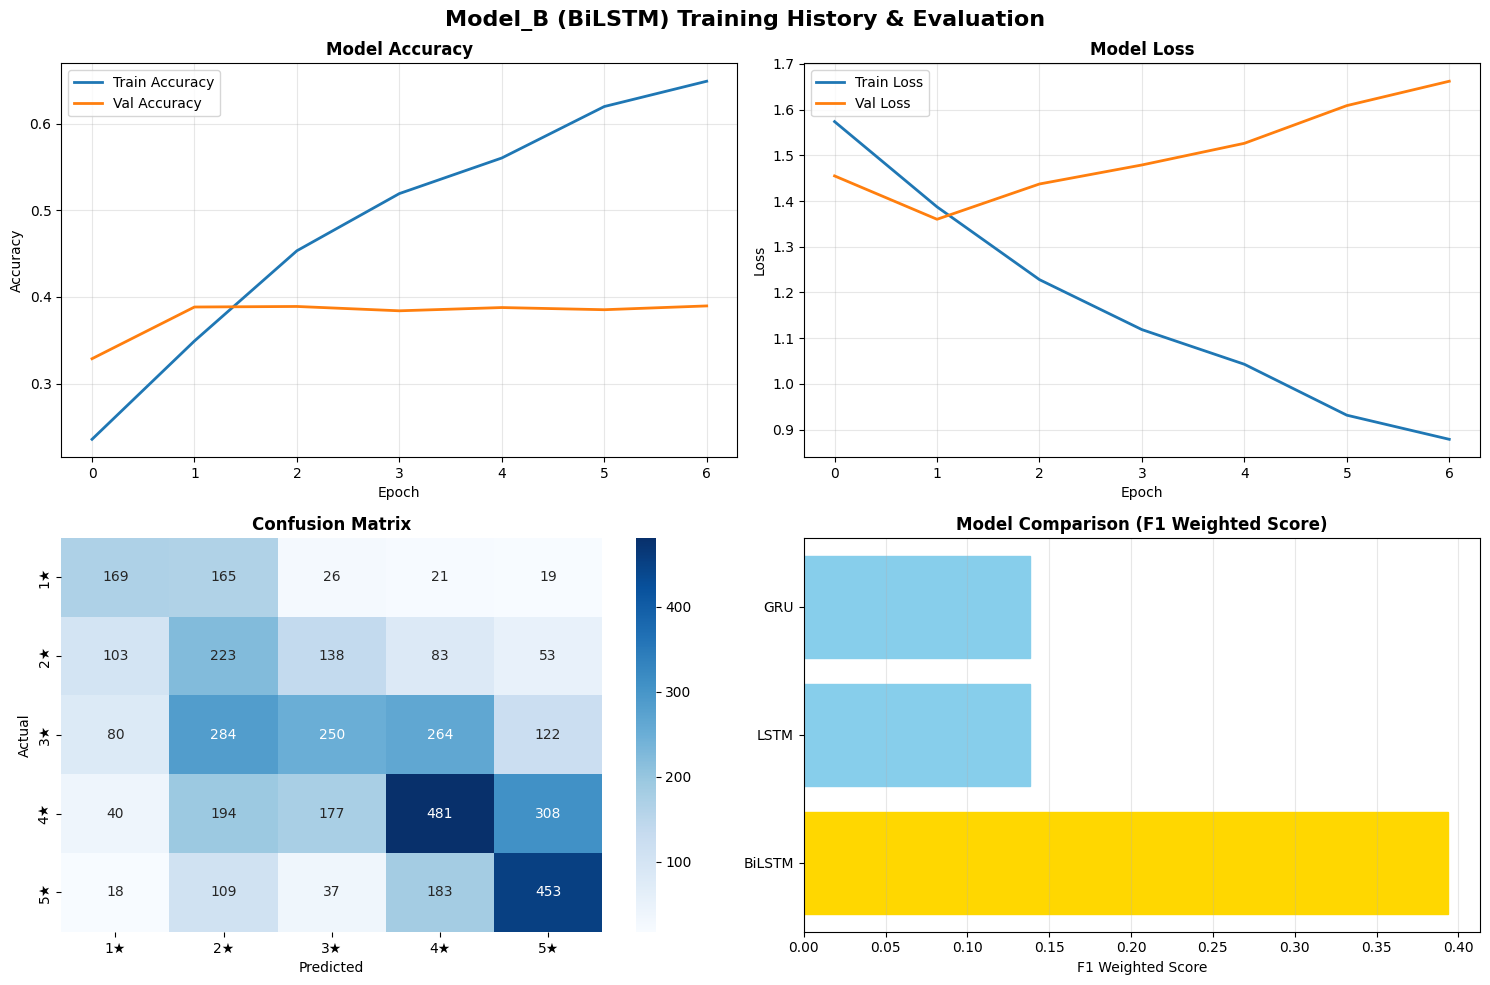


🥇 BEST MODEL: BiLSTM
   Training Accuracy: 0.3492
   Test Accuracy: 0.3940
   F1 Weighted: 0.3935
   F1 Macro: 0.3910

✅ TRAINING COMPLETE - MODEL_B READY

📦 Files saved:
   • Model: ../models/Model_B.h5
   • Tokenizer: ../models/tokenizer_model_b.pkl
   • Configuration: ../models/model_b_config.txt
   • Visualization: ../models/model_b_visualization.png

🎯 Best Architecture: BiLSTM
   F1 Weighted Score: 0.3935
   Test Accuracy: 0.3940



In [12]:
import numpy as np
import pandas as pd

# Check TensorFlow installation first
try:
    import tensorflow as tf
    print(f"TensorFlow version: {tf.__version__}")
    
    # Import from tensorflow.keras (works with TF 2.x < 2.16)
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import (
        Embedding, LSTM, Dense, Dropout, Bidirectional, 
        Conv1D, GlobalMaxPooling1D, GRU, Input, concatenate,
        SpatialDropout1D, BatchNormalization
    )
    from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
    from tensorflow.keras.optimizers import Adam
    
except (ImportError, AttributeError) as e:
    print(f"Error with tensorflow.keras: {e}")
    print("Trying alternative import method...")
    
    try:
        # Alternative: Use keras-preprocessing package
        import tensorflow as tf
        from keras_preprocessing.text import Tokenizer
        from keras_preprocessing.sequence import pad_sequences
        from tensorflow.keras.models import Sequential, Model
        from tensorflow.keras.layers import (
            Embedding, LSTM, Dense, Dropout, Bidirectional, 
            Conv1D, GlobalMaxPooling1D, GRU, Input, concatenate,
            SpatialDropout1D, BatchNormalization
        )
        from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
        from tensorflow.keras.optimizers import Adam
        print("Using keras-preprocessing package")
    except ImportError:
        print("\n" + "=" * 80)
        print("❌ INSTALLATION ERROR")
        print("=" * 80)
        print("\nPlease run these commands:")
        print("pip uninstall tensorflow keras tf-keras -y")
        print("pip install tensorflow==2.15.0 keras-preprocessing")
        print("=" * 80)
        raise

from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("=" * 80)
print("🚀 DEEP LEARNING TRAINING PIPELINE - MODEL_B")
print("=" * 80)

# ============================================================================
# 1. LOAD DATA
# ============================================================================
print("\n📂 Loading training and test data...")
train_df = pd.read_csv('../data/imbalanced_dataset/train_imbalanced.csv')
test_df = pd.read_csv('../data/imbalanced_dataset/test_imbalanced.csv')

X_train = train_df['Cleaned_summary'].values
y_train = train_df['Score'].values - 1  # Convert to 0-4 for neural networks

X_test = test_df['Cleaned_summary'].values
y_test = test_df['Score'].values - 1

print(f"✅ Training samples: {len(X_train)}")
print(f"✅ Test samples: {len(X_test)}")

# ============================================================================
# 2. TOKENIZATION
# ============================================================================
print("\n" + "=" * 80)
print("🔤 TOKENIZATION")
print("=" * 80)

# Hyperparameters
MAX_WORDS = 10000  # Vocabulary size
MAX_LEN = 100      # Maximum sequence length
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

vocab_size = len(tokenizer.word_index) + 1

print(f"✅ Vocabulary size: {vocab_size}")
print(f"✅ Max sequence length: {MAX_LEN}")
print(f"✅ Embedding dimension: {EMBEDDING_DIM}")
print(f"✅ Train sequences shape: {X_train_pad.shape}")
print(f"✅ Test sequences shape: {X_test_pad.shape}")

# ============================================================================
# 3. MODEL ARCHITECTURES
# ============================================================================
print("\n" + "=" * 80)
print("🏗️ BUILDING MODEL ARCHITECTURES")
print("=" * 80)

def create_lstm_model():
    """Simple LSTM Model"""
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ], name='LSTM_Model')
    return model

def create_bilstm_model():
    """Bidirectional LSTM Model"""
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ], name='BiLSTM_Model')
    return model

def create_gru_model():
    """GRU Model"""
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        GRU(64, return_sequences=True),
        Dropout(0.3),
        GRU(32),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ], name='GRU_Model')
    return model

def create_cnn_lstm_model():
    """CNN-LSTM Hybrid Model"""
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        Conv1D(128, 5, activation='relu'),
        Dropout(0.3),
        LSTM(64, return_sequences=True),
        Dropout(0.3),
        LSTM(32),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ], name='CNN_LSTM_Model')
    return model

def create_deep_bilstm_model():
    """Deep Bidirectional LSTM Model (Best Architecture)"""
    model = Sequential([
        Embedding(vocab_size, EMBEDDING_DIM, input_length=MAX_LEN),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.4),
        Bidirectional(LSTM(32)),
        Dropout(0.4),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')
    ], name='Deep_BiLSTM_Model')
    return model

# ============================================================================
# 4. TRAINING FUNCTION
# ============================================================================
def train_model(model, model_name, epochs=30, batch_size=64):
    """Train a model and return history and best weights"""
    print(f"\n{'=' * 80}")
    print(f"🎯 Training {model_name}")
    print(f"{'=' * 80}")
    
    # Compile model with class weights for imbalanced data
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Calculate class weights
    from sklearn.utils.class_weight import compute_class_weight
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    
    print(f"📊 Class weights: {class_weight_dict}")
    
    # Callbacks
    checkpoint_path = f'../models/{model_name}_best.h5'
    callbacks_list = [
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1)
    ]
    
    # Train
    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test_pad, y_test, verbose=0)
    y_pred = np.argmax(model.predict(X_test_pad, verbose=0), axis=1)
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n📊 {model_name} Results:")
    print(f"  Test Accuracy: {test_acc:.4f}")
    print(f"  Test Loss: {test_loss:.4f}")
    print(f"  F1 Score (Weighted): {f1_weighted:.4f}")
    print(f"  F1 Score (Macro): {f1_macro:.4f}")
    
    return {
        'model': model,
        'history': history,
        'test_acc': test_acc,
        'test_loss': test_loss,
        'f1_weighted': f1_weighted,
        'f1_macro': f1_macro,
        'name': model_name
    }

# ============================================================================
# 5. TRAIN SELECTED MODELS (LSTM, BiLSTM, GRU ONLY)
# ============================================================================
print("\n" + "=" * 80)
print("🚂 TRAINING SELECTED MODELS (LSTM, BiLSTM, GRU)")
print("=" * 80)

models_to_train = [
    (create_lstm_model(), 'LSTM'),
    (create_bilstm_model(), 'BiLSTM'),
    (create_gru_model(), 'GRU')
]

results = []
for model, name in models_to_train:
    result = train_model(model, name, epochs=30, batch_size=64)
    results.append(result)

# ============================================================================
# 6. SELECT BEST MODEL AS MODEL_B
# ============================================================================
print("\n" + "=" * 80)
print("🏆 MODEL COMPARISON & SELECTION")
print("=" * 80)

# Create comparison dataframe
comparison_df = pd.DataFrame([
    {
        'Model': r['name'],
        'Test Accuracy': r['test_acc'],
        'Test Loss': r['test_loss'],
        'F1 Weighted': r['f1_weighted'],
        'F1 Macro': r['f1_macro']
    }
    for r in results
])

print("\n📊 Model Performance Comparison:")
print(comparison_df.to_string(index=False))

# Select best model based on F1 Weighted score (best for imbalanced data)
best_idx = comparison_df['F1 Weighted'].idxmax()
best_result = results[best_idx]
best_model = best_result['model']
best_name = best_result['name']

print(f"\n🥇 BEST MODEL: {best_name}")
print(f"   Test Accuracy: {best_result['test_acc']:.4f}")
print(f"   F1 Weighted: {best_result['f1_weighted']:.4f}")
print(f"   F1 Macro: {best_result['f1_macro']:.4f}")

# ============================================================================
# 7. SAVE MODEL_B
# ============================================================================
print("\n" + "=" * 80)
print("💾 SAVING MODEL_B")
print("=" * 80)

# Save the best model as Model_B
model_b_path = '../models/Model_B.h5'
best_model.save(model_b_path)
print(f"✅ Model_B saved to: {model_b_path}")

# Save tokenizer
import pickle
tokenizer_path = '../models/tokenizer_model_b.pkl'
with open(tokenizer_path, 'wb') as f:
    pickle.dump(tokenizer, f)
print(f"✅ Tokenizer saved to: {tokenizer_path}")

# Save model configuration
config_path = '../models/model_b_config.txt'
with open(config_path, 'w') as f:
    f.write(f"MODEL_B Configuration\n")
    f.write(f"=" * 50 + "\n")
    f.write(f"Architecture: {best_name}\n")
    f.write(f"Vocabulary Size: {vocab_size}\n")
    f.write(f"Max Sequence Length: {MAX_LEN}\n")
    f.write(f"Embedding Dimension: {EMBEDDING_DIM}\n")
    f.write(f"\nPerformance Metrics:\n")
    f.write(f"Test Accuracy: {best_result['test_acc']:.4f}\n")
    f.write(f"F1 Weighted: {best_result['f1_weighted']:.4f}\n")
    f.write(f"F1 Macro: {best_result['f1_macro']:.4f}\n")
print(f"✅ Configuration saved to: {config_path}")

# ============================================================================
# 8. DETAILED EVALUATION OF MODEL_B
# ============================================================================
print("\n" + "=" * 80)
print("📈 DETAILED EVALUATION OF MODEL_B")
print("=" * 80)

# Predictions
y_pred = np.argmax(best_model.predict(X_test_pad, verbose=0), axis=1)

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ============================================================================
# 9. VISUALIZATION
# ============================================================================
print("\n" + "=" * 80)
print("📊 GENERATING VISUALIZATIONS")
print("=" * 80)

# Plot training history for best model
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Model_B ({best_name}) Training History & Evaluation', fontsize=16, fontweight='bold')

# Accuracy plot
axes[0, 0].plot(best_result['history'].history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0, 0].plot(best_result['history'].history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss plot
axes[0, 1].plot(best_result['history'].history['loss'], label='Train Loss', linewidth=2)
axes[0, 1].plot(best_result['history'].history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 1].set_title('Model Loss', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['1★', '2★', '3★', '4★', '5★'],
            yticklabels=['1★', '2★', '3★', '4★', '5★'])
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Model Comparison Bar Chart
comparison_df_sorted = comparison_df.sort_values('F1 Weighted', ascending=False)
bars = axes[1, 1].barh(comparison_df_sorted['Model'], comparison_df_sorted['F1 Weighted'])
bars[0].set_color('gold')  # Highlight best model
for i in range(1, len(bars)):
    bars[i].set_color('skyblue')
axes[1, 1].set_title('Model Comparison (F1 Weighted Score)', fontweight='bold')
axes[1, 1].set_xlabel('F1 Weighted Score')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
viz_path = '../models/model_b_visualization.png'
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"✅ Visualization saved to: {viz_path}")
plt.show()

# Get training accuracy from best epoch
best_epoch_idx = np.argmin(best_result['history'].history['val_loss'])
train_acc = best_result['history'].history['accuracy'][best_epoch_idx]

print(f"\n🥇 BEST MODEL: {best_name}")
print(f"   Training Accuracy: {train_acc:.4f}")
print(f"   Test Accuracy: {best_result['test_acc']:.4f}")
print(f"   F1 Weighted: {best_result['f1_weighted']:.4f}")
print(f"   F1 Macro: {best_result['f1_macro']:.4f}")

# ============================================================================
# 10. SUMMARY
# ============================================================================
print("\n" + "=" * 80)
print("✅ TRAINING COMPLETE - MODEL_B READY")
print("=" * 80)
print(f"\n📦 Files saved:")
print(f"   • Model: {model_b_path}")
print(f"   • Tokenizer: {tokenizer_path}")
print(f"   • Configuration: {config_path}")
print(f"   • Visualization: {viz_path}")
print(f"\n🎯 Best Architecture: {best_name}")
print(f"   F1 Weighted Score: {best_result['f1_weighted']:.4f}")
print(f"   Test Accuracy: {best_result['test_acc']:.4f}")
print("\n" + "=" * 80)

test

📥 LOADING MODEL AND TOKENIZER


✅ Model_A loaded successfully!
✅ Tokenizer loaded successfully!

📋 Model Information:
   Model Type: CNN
   Max Words: 10000
   Max Length: 100
   Original Test Accuracy (Balanced): 0.3884

📂 LOADING IMBALANCED TEST DATA
✅ Loaded 4000 test samples

📊 Test Set Distribution:
   1 Star:  400 samples (10.0%)
   2 Star:  600 samples (15.0%)
   3 Star: 1000 samples (25.0%)
   4 Star: 1200 samples (30.0%)
   5 Star:  800 samples (20.0%)

🔧 PREPROCESSING TEST DATA
✅ Test data shape: (4000, 100)
✅ Preprocessed 4000 samples

🔮 MAKING PREDICTIONS
✅ Predictions complete!

📊 PERFORMANCE METRICS

🎯 Overall Accuracy: 0.3767 (37.67%)
📈 Cohen's Kappa Score: 0.2212

📋 PER-CLASS PERFORMANCE
Rating     Samples    Precision    Recall       F1-Score    
------------------------------------------------------------
1 Star     400        0.2713       0.5025       0.3523      
2 Star     600        0.2485       0.2767       0.2618      
3 Star     1000       0.4098       0.2590       0.3174      
4 Star     120

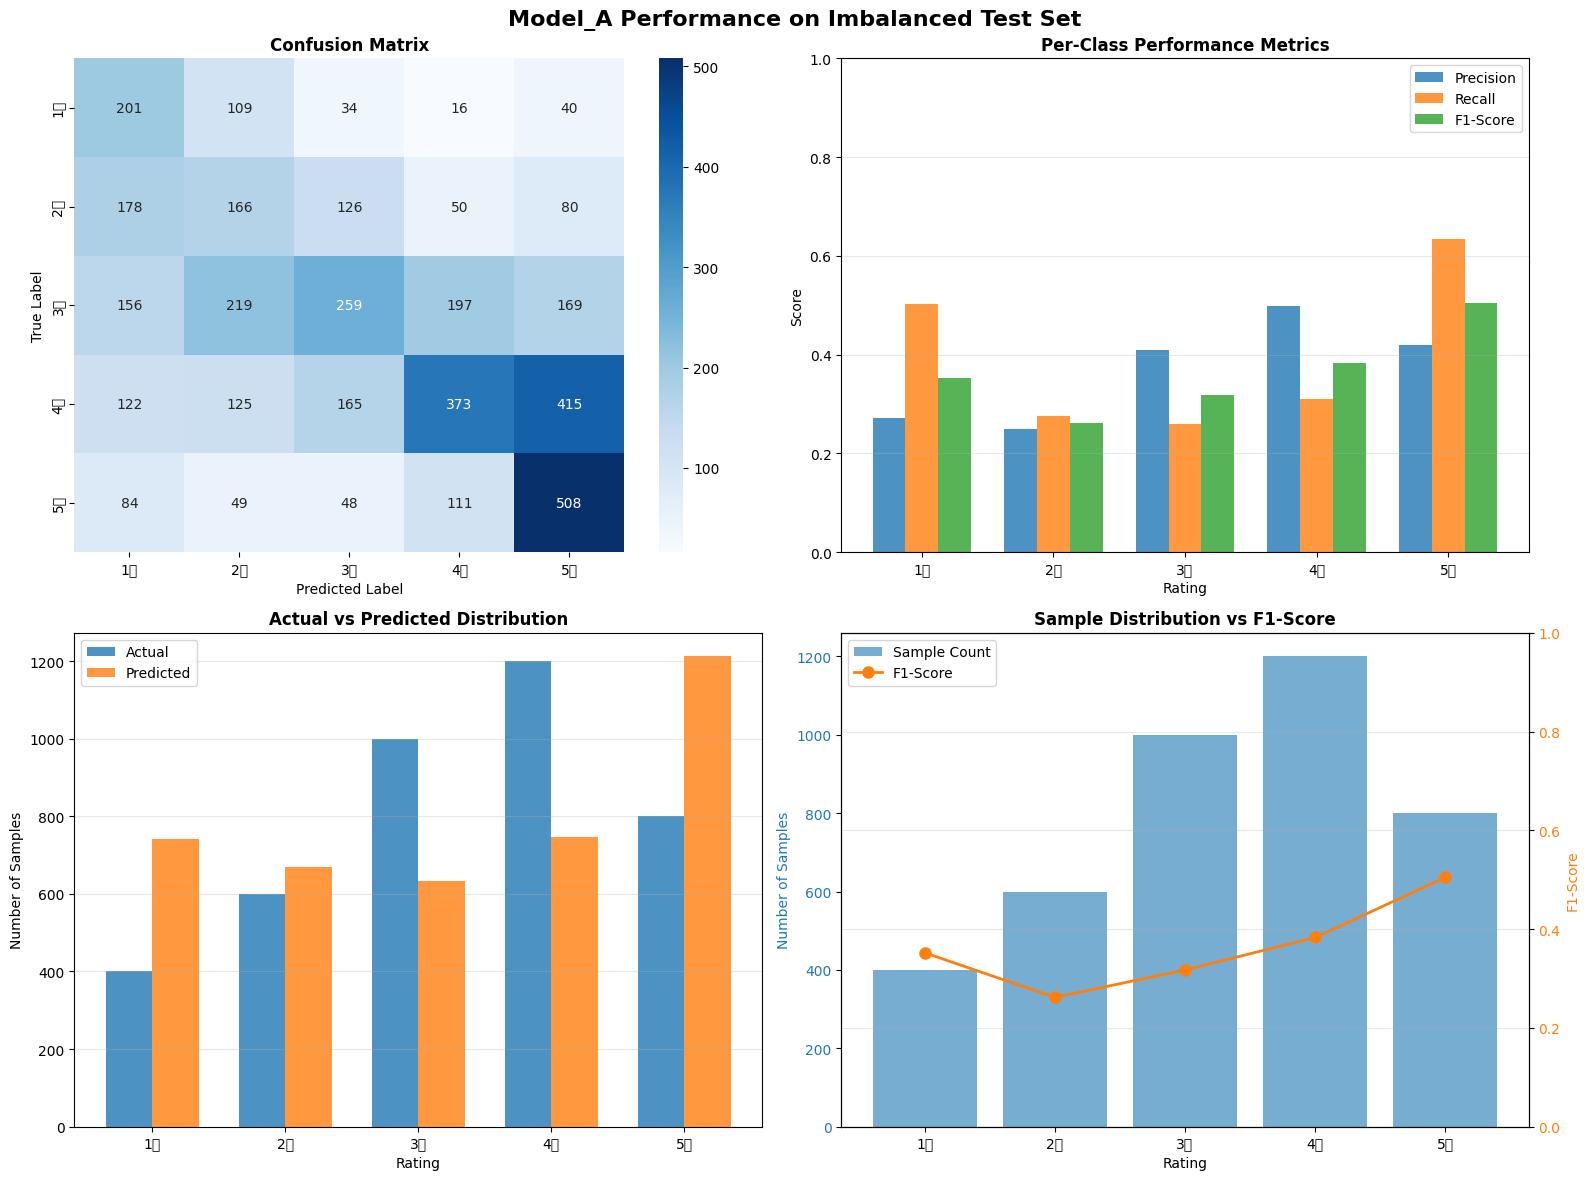


🔍 ERROR ANALYSIS

📏 Mean Absolute Error: 0.9952 stars

📊 Error Distribution:
   Off by 0 star(s): 1507 samples (37.67%)
   Off by 1 star(s): 1520 samples (38.00%)
   Off by 2 star(s):  582 samples (14.55%)
   Off by 3 star(s):  267 samples (6.68%)
   Off by 4 star(s):  124 samples (3.10%)

🎯 Predictions within ±1 star: 75.67%

💾 SAVING RESULTS
✅ Results saved to: ../models/imbalanced_test_results.pkl
✅ Detailed metrics saved to: ../models/imbalanced_test_metrics.csv

📈 PERFORMANCE COMPARISON

Balanced Dataset Test Accuracy:   0.3884
Imbalanced Dataset Test Accuracy: 0.3767
Difference:                        -0.0117

⚠️  Model performs worse on imbalanced data
   This is expected due to class imbalance

✨ TESTING COMPLETE!


In [13]:
import numpy as np
import pandas as pd
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    cohen_kappa_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================================
# 1. LOAD MODEL AND TOKENIZER
# =====================================================================
print("="*60)
print("📥 LOADING MODEL AND TOKENIZER")
print("="*60)

# Load the trained model
model = load_model('../models/A/Model_A.h5')
print("✅ Model_A loaded successfully!")

# Load tokenizer
with open('../models/A/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)
print("✅ Tokenizer loaded successfully!")

# Load model metadata
with open('../models/A/model_metadata.pkl', 'rb') as f:
    metadata = pickle.load(f)

print(f"\n📋 Model Information:")
print(f"   Model Type: {metadata['model_type']}")
print(f"   Max Words: {metadata['max_words']}")
print(f"   Max Length: {metadata['max_len']}")
print(f"   Original Test Accuracy (Balanced): {metadata['test_accuracy']:.4f}")

MAX_LEN = metadata['max_len']

# =====================================================================
# 2. LOAD IMBALANCED TEST DATA
# =====================================================================
print("\n" + "="*60)
print("📂 LOADING IMBALANCED TEST DATA")
print("="*60)

test_df = pd.read_csv('../data/imbalanced_dataset/test_imbalanced.csv')
print(f"✅ Loaded {len(test_df)} test samples")

X_test = test_df['Cleaned_summary']
y_test = test_df['Score']

# Display distribution
print("\n📊 Test Set Distribution:")
test_dist = y_test.value_counts().sort_index()
for rating in sorted(test_dist.index):
    count = test_dist[rating]
    percentage = (count / len(y_test)) * 100
    print(f"   {rating} Star: {count:4d} samples ({percentage:.1f}%)")

# =====================================================================
# 3. PREPROCESS TEST DATA
# =====================================================================
print("\n" + "="*60)
print("🔧 PREPROCESSING TEST DATA")
print("="*60)

# Convert text to sequences
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# Convert labels to 0-4 range (to match model training)
y_test_model = y_test - 1  # Score 1-5 becomes 0-4

print(f"✅ Test data shape: {X_test_pad.shape}")
print(f"✅ Preprocessed {len(X_test_pad)} samples")

# =====================================================================
# 4. MAKE PREDICTIONS
# =====================================================================
print("\n" + "="*60)
print("🔮 MAKING PREDICTIONS")
print("="*60)

# Get predictions (probabilities)
y_pred_proba = model.predict(X_test_pad, verbose=0)

# Get predicted classes
y_pred = np.argmax(y_pred_proba, axis=1)

# Convert predictions back to 1-5 scale
y_pred_original = y_pred + 1
y_test_original = y_test_model + 1

print("✅ Predictions complete!")

# =====================================================================
# 5. CALCULATE METRICS
# =====================================================================
print("\n" + "="*60)
print("📊 PERFORMANCE METRICS")
print("="*60)

# Overall accuracy
accuracy = accuracy_score(y_test_original, y_pred_original)
print(f"\n🎯 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Cohen's Kappa Score (agreement between predicted and actual)
kappa = cohen_kappa_score(y_test_original, y_pred_original)
print(f"📈 Cohen's Kappa Score: {kappa:.4f}")

# Per-class metrics
precision, recall, f1, support = precision_recall_fscore_support(
    y_test_original, 
    y_pred_original, 
    labels=[1, 2, 3, 4, 5],
    zero_division=0
)

print("\n" + "="*60)
print("📋 PER-CLASS PERFORMANCE")
print("="*60)
print(f"{'Rating':<10} {'Samples':<10} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-"*60)

for i, rating in enumerate([1, 2, 3, 4, 5]):
    print(f"{rating} Star{'':<4} {support[i]:<10} {precision[i]:<12.4f} {recall[i]:<12.4f} {f1[i]:<12.4f}")

# Calculate macro and weighted averages
macro_precision = np.mean(precision)
macro_recall = np.mean(recall)
macro_f1 = np.mean(f1)

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print("-"*60)
print(f"{'Macro Avg':<10} {len(y_test):<10} {macro_precision:<12.4f} {macro_recall:<12.4f} {macro_f1:<12.4f}")
print(f"{'Weighted':<10} {len(y_test):<10} {weighted_precision:<12.4f} {weighted_recall:<12.4f} {weighted_f1:<12.4f}")

# =====================================================================
# 6. CONFUSION MATRIX
# =====================================================================
print("\n" + "="*60)
print("🔢 CONFUSION MATRIX")
print("="*60)

cm = confusion_matrix(y_test_original, y_pred_original, labels=[1, 2, 3, 4, 5])
print("\nConfusion Matrix:")
print(cm)

# =====================================================================
# 7. DETAILED CLASSIFICATION REPORT
# =====================================================================
print("\n" + "="*60)
print("📑 DETAILED CLASSIFICATION REPORT")
print("="*60)

target_names = ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star']
print("\n" + classification_report(y_test_original, y_pred_original, target_names=target_names))

# =====================================================================
# 8. VISUALIZATIONS
# =====================================================================
print("\n" + "="*60)
print("📊 CREATING VISUALIZATIONS")
print("="*60)

# Create figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model_A Performance on Imbalanced Test Set', fontsize=16, fontweight='bold')

# 1. Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
            xticklabels=['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'],
            yticklabels=['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])
axes[0, 0].set_title('Confusion Matrix', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('True Label')
axes[0, 0].set_xlabel('Predicted Label')

# 2. Per-Class Performance Comparison
x = np.arange(5)
width = 0.25
axes[0, 1].bar(x - width, precision, width, label='Precision', alpha=0.8)
axes[0, 1].bar(x, recall, width, label='Recall', alpha=0.8)
axes[0, 1].bar(x + width, f1, width, label='F1-Score', alpha=0.8)
axes[0, 1].set_xlabel('Rating')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Per-Class Performance Metrics', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')
axes[0, 1].set_ylim([0, 1])

# 3. Class Distribution (Actual vs Predicted)
actual_dist = pd.Series(y_test_original).value_counts().sort_index()
pred_dist = pd.Series(y_pred_original).value_counts().sort_index()

# Ensure all classes are represented
for rating in [1, 2, 3, 4, 5]:
    if rating not in actual_dist.index:
        actual_dist[rating] = 0
    if rating not in pred_dist.index:
        pred_dist[rating] = 0

actual_dist = actual_dist.sort_index()
pred_dist = pred_dist.sort_index()

x = np.arange(5)
width = 0.35
axes[1, 0].bar(x - width/2, actual_dist.values, width, label='Actual', alpha=0.8)
axes[1, 0].bar(x + width/2, pred_dist.values, width, label='Predicted', alpha=0.8)
axes[1, 0].set_xlabel('Rating')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_title('Actual vs Predicted Distribution', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Support and F1-Score Comparison
x = np.arange(5)
ax1 = axes[1, 1]
ax2 = ax1.twinx()

color1 = 'tab:blue'
color2 = 'tab:orange'

bars = ax1.bar(x, support, alpha=0.6, color=color1, label='Sample Count')
ax1.set_xlabel('Rating')
ax1.set_ylabel('Number of Samples', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(x)
ax1.set_xticklabels(['1⭐', '2⭐', '3⭐', '4⭐', '5⭐'])

line = ax2.plot(x, f1, color=color2, marker='o', linewidth=2, markersize=8, label='F1-Score')
ax2.set_ylabel('F1-Score', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')

axes[1, 1].set_title('Sample Distribution vs F1-Score', fontweight='bold', fontsize=12)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.savefig('../models/imbalanced_test_results.png', dpi=300, bbox_inches='tight')
print("✅ Visualizations saved to: ../models/imbalanced_test_results.png")
plt.show()

# =====================================================================
# 9. ERROR ANALYSIS
# =====================================================================
print("\n" + "="*60)
print("🔍 ERROR ANALYSIS")
print("="*60)

# Calculate prediction errors
errors = np.abs(y_test_original - y_pred_original)
mean_error = np.mean(errors)
print(f"\n📏 Mean Absolute Error: {mean_error:.4f} stars")

# Distribution of errors
print("\n📊 Error Distribution:")
error_dist = pd.Series(errors).value_counts().sort_index()
for error_val, count in error_dist.items():
    percentage = (count / len(errors)) * 100
    print(f"   Off by {int(error_val)} star(s): {count:4d} samples ({percentage:.2f}%)")

# Percentage of predictions within 1 star
within_1_star = np.sum(errors <= 1) / len(errors) * 100
print(f"\n🎯 Predictions within ±1 star: {within_1_star:.2f}%")

# =====================================================================
# 10. SAVE RESULTS
# =====================================================================
print("\n" + "="*60)
print("💾 SAVING RESULTS")
print("="*60)

# Create results dictionary
results_dict = {
    'overall_accuracy': accuracy,
    'cohen_kappa': kappa,
    'mean_absolute_error': mean_error,
    'within_1_star_percentage': within_1_star,
    'per_class_metrics': {
        'precision': precision.tolist(),
        'recall': recall.tolist(),
        'f1_score': f1.tolist(),
        'support': support.tolist()
    },
    'confusion_matrix': cm.tolist(),
    'macro_avg': {
        'precision': macro_precision,
        'recall': macro_recall,
        'f1_score': macro_f1
    },
    'weighted_avg': {
        'precision': weighted_precision,
        'recall': weighted_recall,
        'f1_score': weighted_f1
    }
}

# Save results to pickle
with open('../models/imbalanced_test_results.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

print("✅ Results saved to: ../models/imbalanced_test_results.pkl")

# Create detailed results CSV
results_df = pd.DataFrame({
    'Rating': ['1 Star', '2 Star', '3 Star', '4 Star', '5 Star'],
    'Support': support,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
})

results_df.to_csv('../models/imbalanced_test_metrics.csv', index=False)
print("✅ Detailed metrics saved to: ../models/imbalanced_test_metrics.csv")

# =====================================================================
# 11. COMPARISON WITH BALANCED DATASET PERFORMANCE
# =====================================================================
print("\n" + "="*60)
print("📈 PERFORMANCE COMPARISON")
print("="*60)
print(f"\nBalanced Dataset Test Accuracy:   {metadata['test_accuracy']:.4f}")
print(f"Imbalanced Dataset Test Accuracy: {accuracy:.4f}")
print(f"Difference:                        {accuracy - metadata['test_accuracy']:.4f}")

if accuracy < metadata['test_accuracy']:
    print("\n⚠️  Model performs worse on imbalanced data")
    print("   This is expected due to class imbalance")
else:
    print("\n✅ Model maintains good performance on imbalanced data!")

print("\n" + "="*60)
print("✨ TESTING COMPLETE!")
print("="*60)